# ENEL 645 Final Project - Recognizing American Sign Language

Dependencies:

- Create a new conda environment
- `$ conda install -c anaconda tensorflow==2.9.1 matplotlib scikit-image kaggle`


In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform
import os

print(tf.__version__)

/home/ec2-user/anaconda3/envs/ai/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


## Load dataset, explore it and split it into train, validation and test sets


If you are running this tutorial locally such as in vsCode, download the dataset in the link below, unzip, and save in a new local folder called /asl-alphabet.

### Larger dataset

https://www.kaggle.com/datasets/grassknoted/asl-alphabet

### Smaller dataset

https://www.kaggle.com/datasets/danrasband/asl-alphabet-test

If running this tutorial google colab, follow this link (https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to download an api key kaggle.json file from your kaggle acount and uncomment and the following code to download the dataset directly from kaggle.


## Code for downloading the dataset directly from Kaggle using unique api key


In [2]:
# Create new directory 
! mkdir asl_alphabet 
# Download dataset from kaggle
! KAGGLE_USERNAME=tysontrail KAGGLE_KEY=29decad2f17556a9de6abf9e5b93dc21 kaggle datasets download -d grassknoted/asl-alphabet 
# Unzip and save in newly created directory
! unzip -f -q asl-alphabet.zip -d asl_alphabet/ 

Keyring is skipped due to an exception: 'keyring.backends'
mkdir: cannot create directory ‘asl_alphabet’: File exists
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


## Set Datasets Using Dataset From Directory Class

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory


In [3]:
# Create class names
class_names = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "del",
    "nothing",
    "space",
]

# Paths to the downloaded dataset
train_dir = "asl_alphabet/asl_alphabet_train/asl_alphabet_train"

# Parameters of images in the dataset
IMG_SIZE = (224, 224)

BATCH_SIZE = 28

# set the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode="categorical",
)


Found 87000 files belonging to 29 classes.


2023-04-01 06:04:33.673497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 06:04:33.674149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Plot Samples From the first batch of training data


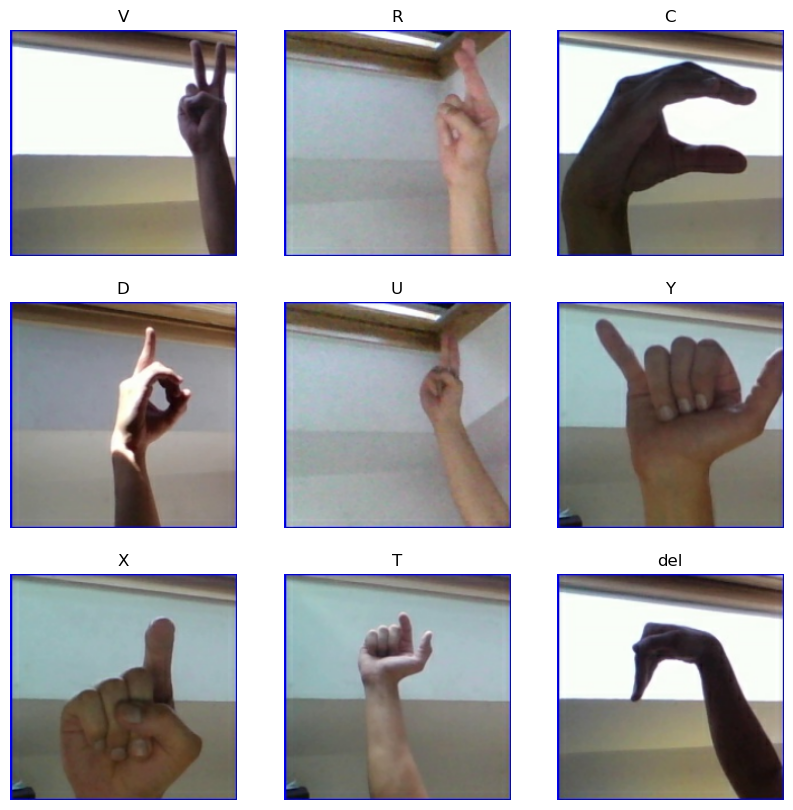

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


## Split dataset Into train and test

First Split into train and test datasets. 20% is dedicated to testing, and 80% to training.


In [5]:
training_batches = tf.data.experimental.cardinality(train_dataset)
number_of_batches_for_testing = training_batches // 5
test_dataset = train_dataset.take(number_of_batches_for_testing)
train_dataset = train_dataset.skip(number_of_batches_for_testing)

print(
    "Number of training batches: %d"
    % tf.data.experimental.cardinality(train_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)


Number of training batches: 2487
Number of test batches: 621


## Now split test into test and validation

Split the 20% of testing in half: 10% for to testing, and 10% to validation


In [6]:
number_of_batches_for_validation = number_of_batches_for_testing // 2
validation_dataset = test_dataset.take(number_of_batches_for_validation)
test_dataset = test_dataset.skip(number_of_batches_for_validation)


In [7]:
print(
    "Number of training batches: %d"
    % tf.data.experimental.cardinality(train_dataset)
)
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)


Number of training batches: 2487
Number of validation batches: 310
Number of test batches: 311


## Improve Runtime

https://www.tensorflow.org/guide/data_performance


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Define data augmentation steps

In real life, signs won't be perfect, here we augment the data using realistic movements that could be found in practice. Most signs will be well aligned though, is not reasonable to expect a sign that's too far from the standard pose, so 5% is a reasonable compromise.


In [9]:
data_augmentation = tf.keras.Sequential(
    [
        # Some images may be closer to the camera, or farther
        tf.keras.layers.RandomZoom(0.05, 0.05),
        # Signs may not be perfectly aligned in the center of the image
        tf.keras.layers.RandomTranslation(0.05, 0.05),
        # Signs may be a little bit rotated with respect to the vertical axis
        tf.keras.layers.RandomRotation(0.05),
    ]
)


## Imput pre-processing Steps

Since our model is EfficientNetB2, we use the efficientnet preprocessor


In [10]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input


## Transfer Learning

Load pre-trained model on imagenet, but excluding the top layer (prediction layer)


In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)


### View model summary


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(28, 7, 7, 1408)


### Freeze the layers (i.e., make them non-trainable) of the pretrained model


In [13]:
base_model.trainable = False


In [ ]:
### Checkout the model architecture


In [14]:
base_model.summary()


Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 144)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 528)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 88)   46464       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 88)  352         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 88)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block5a_project_bn (BatchNorma  (None, 14, 14, 120)  480        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 720)  86400       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 720)  2880       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 720)  0          ['block5b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 14, 14, 720)  2880       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 720)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 14, 14, 720)  18000      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_b

 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1248)  31200       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 1248)  4992        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1248)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1248)        0           ['block6b_activation[0][0]']     
 agePoolin

                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1248)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1248)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block6d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1248)   66144       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1248)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
          

In [ ]:
### Start creating our custom layers


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape


(28, 1408)


In [16]:
prediction_layer = tf.keras.layers.Dense(29, activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape


(28, 29)


### Build model by chaining preprocessing steps


In [17]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Augment
augmented = data_augmentation(inputs)
# Preprocess
preprocessed = preprocess_input(augmented)
# Add base model
with_base_model = base_model(preprocessed, training=False)
with_global_average_layer = global_average_layer(with_base_model)
# Prevent overfitting by using dropout
with_dropout = tf.keras.layers.Dropout(0.2)(with_global_average_layer)
# Predict
outputs = prediction_layer(with_dropout)
model = tf.keras.Model(inputs, outputs)


### Set optimizer, learing rate loss, etc...


In [18]:
# This is the output of our training, we'll use this to feed the live camera detection system
model_name = "training_classifier_asl.h5"

# Add an early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Save the model as it is trained
monitor = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
)
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch % 4 == 0 and epoch != 0:
        lr = lr / 2
    return lr


# Schedule the learning rate to decrease over time
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

# Pick a very low learning rate since we don't want to overfit the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)


In [ ]:
### Our model architecture


In [19]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 29)                40861     
                                                             

### Evaluate the model before any training happens

Accuracy is worst than guessing of course, we'll traing it soon


In [20]:
loss0, accuracy0 = model.evaluate(validation_dataset)


310/310 [==============================] - 118s 373ms/step - loss: 3.5147 - accuracy: 0.0222


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 3.51
initial accuracy: 0.02


## Train the classifier layer

At this point we want to traing the classifier layer


In [ ]:
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=[early_stop, monitor, lr_schedule],
)


Epoch 1/15
2487/2487 [==============================] - ETA: 0s - loss: 1.7542 - accuracy: 0.6724
Epoch 1: val_loss improved from inf to 0.97374, saving model to training_classifier_asl.h5
2487/2487 [==============================] - 1017s 406ms/step - loss: 1.7542 - accuracy: 0.6724 - val_loss: 0.9737 - val_accuracy: 0.8787 - lr: 1.0000e-04
Epoch 2/15
1941/2487 [======================>.......] - ETA: 3:18 - loss: 0.7645 - accuracy: 0.8984

### Plot some nice looking charts


In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


## Second training cycle - Fine Tuning

Reduced learning rate and all parameters trainable


In [ ]:
model = tf.keras.models.load_model(model_name)
model.trainable = True


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-8),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [ ]:
model.summary()


In [ ]:
model.fit(
    train_dataset,
    epochs=3,
    verbose=1,
    callbacks=[early_stop, monitor, lr_schedule],
    validation_data=(validation_dataset),
)
